In [1]:
%display latex

# Black Hole Rendering
Following work by [Florentin Jaffredo](https://sagemanifolds.obspm.fr/gallery.html), relying on SageMath's geodesic integrator.

The approach is to use null-geodesics around an [Eddington-Finkelstein](https://en.wikipedia.org/wiki/Eddington%E2%80%93Finkelstein_coordinates) black hole, as the coordinates behave desireably when computing null-geodesics around the event horizon.

We will assume spherical symmetry to reduce the number of geodesic calculations required.

The spacetime we work in will be declared as

In [2]:
# manifold
M = Manifold(4, "M", structure="Lorentzian")
# chart
C.<t, r, theta, phi> = M.chart(r"t r:(1,+oo) theta:(0,pi):\theta phi:\phi")

C.coord_range()

t: (-oo, +oo); r: (1, +oo); theta: (0, pi); phi: (-oo, +oo)

with a metric $g$ for central mass $m$

In [3]:
m = var('m')
g = M.metric()

# basis
g[0,0] = -(1 - 2*m/r)
g[0,1] = 2*m/r
g[1,1] = 1 + 2*m/r
g[2,2] = r^2
g[3,3] = (r*sin(theta))^2

g[:]

[       2*m/r - 1            2*m/r                0                0]
[           2*m/r        2*m/r + 1                0                0]
[               0                0              r^2                0]
[               0                0                0 r^2*sin(theta)^2]

We also require an Euclidean space to present and plot results in, for which we define a map to our manifold:

In [4]:
E.<x, y, z> = EuclideanSpace()

# transform map
phimap = M.diff_map(
    E,
    [
        r*sin(theta)*cos(phi),
        r*sin(theta)*sin(phi),
        r*cos(theta)
    ]
)

phimap.display()

M --> E^3
   (t, r, theta, phi) |--> (x, y, z) = (r*cos(phi)*sin(theta), r*sin(phi)*sin(theta), r*cos(theta))

## Plotting geodesics
We will use the `integrated_geodesic` functionality of [SageManifold](https://doc.sagemath.org/html/en/reference/manifolds/sage/manifolds/differentiable/integrated_curve.html)

In [5]:
import multiprocessing
from ipywidgets import FloatProgress
from IPython.display import display

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [6]:
BATCH_PER_CPU = 3
NUM_GEOD = 1000
N_CPU = 8

BH_INDEX = 2

Need to find starting velocities: our conditions are
- past-oriented
- light-like
- pointing towards the blackhole with increasing angle


Spatial components are determined, so we adjust the time component to ensure light-like. For some inital point $p$, we want initial 4-velocity $v$ constrained by the time coordinate $dt$:

In [7]:
dt, y, r0 = var("dt, y, r0")
p = M((0, r0, pi/2, 0)) # initial point
Tp = M.tangent_space(p)
v = Tp((dt, -1, 0, y))

# norm:
g.at(p)(v, v)

r0^2*y^2 + dt^2*(2*m - r0)/r0 - 4*dt*m/r0 + (2*m + r0)/r0

Find $dt$ such that $g=0$, thus

In [8]:
dt_constraint = g.at(p)(v, v).solve(dt)
dt_constraint

[dt == -(sqrt(-(2*m*r0 - r0^2)*y^2 + 1)*r0 - 2*m)/(2*m - r0), dt == (sqrt(-(2*m*r0 - r0^2)*y^2 + 1)*r0 + 2*m)/(2*m - r0)]

Two solutions represent past and future orientation.

Define geodesic problem, including checking for chart boundary:

In [9]:
tau = var("tau", latex_name=r"\tau")

# arbitrary initial vectors required
# seeds the geodesic curve and sets state appropriate
p = M((0, 5, pi/2, 0))
Tp = M.tangent_space(p)
v = Tp((0, 5, 0, 0))
v = v / sqrt(-g.at(p)(v, v)) # normalize

# init curve
curve = M.integrated_geodesic(
    g,
    (tau, 0, 200), # parameterization
    v,
    across_charts=True
)

Prepare multiprocessing steps by packing arguments into tuples

In [10]:
args = []
start = 0

for chunk in chunks(
        range(NUM_GEOD), NUM_GEOD//(BATCH_PER_CPU * N_CPU)
    ):
    args.append((loads(curve.dumps()), start, len(chunk)))
    start += len(chunk)

In [11]:
print("- Final argument tuple : ", args[-1])
print("- Number of argument batches: ", len(args))

- Final argument tuple :  (Integrated geodesic in the 4-dimensional Lorentzian manifold M, 984, 16)
- Number of argument batches:  25


The function used to calculate the geodesic batches:

In [12]:
def calc_geodesic(args):
    """ Multiproc function for calculating `num` geodesics at `n0` """
    curve, n0, num = args
    res = {}
    r = 100
    p = M([0, r, pi/2, 0])
    Tp = M.tangent_space(p)
    
    for i in range(n0, n0+num):
        
        # starting vector
        dy = i * 0.006 / NUM_GEOD # magic number for scanning angle increase
        v = Tp(
            [
                dt_constraint[0].rhs()(r0=r, y=dy, m=2).n(), # numeric
                -1, 0, dy
            ]
        )
        
        # overwrite starting vector in curve
        curve._initial_tangent_vector = v
        
        # integrate
        curve.solve_across_charts(
            step=0.2, 
            parameters_values={m:BH_INDEX}
        )
        
        # copy and clear solutions
        res[i] = (p.coord(), curve._solutions.copy())
        curve._solutions.clear()
    
    return res 
    

Now we execute our code. We store the solutions in `geodesics`, and use the functionality of `Pool` to handle system resources:

In [13]:
geodesics = {}
pool = multiprocessing.Pool(N_CPU)

# display bar
%display plain
progress = FloatProgress(min=0, max=NUM_GEOD)
display(progress)

for i, result in enumerate(
        pool.imap_unordered(calc_geodesic, args)
    ):
    # imap_unordered executes and halts
    progress.value += len(result)
    geodesics.update(result)
    
pool.close()
pool.join()

%display latex

FloatProgress(value=0.0, max=1000.0)

### Visualizing result:
Plotting a subset of the geodesics as curves in spacetime:

In [14]:
bh = sage.plot.plot3d.shapes.Sphere(
    2 * BH_INDEX, 
    color="black", 
    viewer="threejs",
)

for i in range(0, NUM_GEOD, 5 * NUM_GEOD / 100):
    curve._solutions = geodesics[i][1]
    
    # interpolate solutions
    interp = curve.interpolate()
    
    bh += curve.plot_integrated(
        mapping=phimap,
        color=["grey"],
        thickness=2,
        plot_points=200,
        label_axes=False,
        across_charts=True
    )
    
bh.show(xmin=-100)

Graphics3d Object

## Adding an accretion disk
We add an accretion disk to our black hole, from which we will calculate the light ray geodesics.

We use an inner and outer radius, and a tilt angle $\alpha$ on $y$ and $\beta$ on $x$:

In [15]:
BH_INNER = 6 * BH_INDEX
BH_OUTER = 22 * BH_INDEX
alpha_ang = -pi/50
beta_ang = 0

Which we can add to our geodesics plot:

In [16]:
bhdisk = sage.plot.plot3d.shapes.Torus(
    (BH_INNER + BH_OUTER) / 2,
    (BH_INNER - BH_OUTER) / 2,
    color="pink"
).scale(
    1, 1, 0.01 # z-axis shrink
).rotateY(alpha_ang).rotateX(beta_ang)

bh + bhdisk

Graphics3d Object

### Calculating intersects
We transform our geodesic dictionary into a list of lists of coordinates:

In [17]:
geodesics_coords = [
    list(geodesics[i][1].values())[0][0][1].tolist()
    for i in range(len(geodesics))
]

and define a function for detecting intersects with the disk. In Python, this may look like:

In [18]:
def to_xyz(r, theta, phi):
    """ helper function for explicit transformation """
    return (
        r * sin(theta) * cos(phi),
        r * sin(theta) * sin(phi),
        r * cos(theta)
    )

def rotate_alpha_beta(x, y, z, alpha, beta):
    """ helper function for rotation with no fixed points"""
    y, z = (
        y * cos(beta) -  z * sin(beta),
        z * cos(beta) + y * sin(beta)
    )
    return (
        x * cos(alpha) - z * sin(alpha), 
        y, 
        z * cos(alpha) + x * sin(alpha)
    )
    
def intersect_disk(curve):
    """
    return True if curve intersects with disk
    """
    global alpha_ang, beta_ang, BH_INNER, BH_OUTER
    n = len(curve)
    
    # tau, t, r, theta, phi -- unpack only r, theta, phi
    r, theta, phi = curve[0][2:5]
    
    # write out action of phimap for speed
    x, y, z = to_xyz(r, theta, phi)
    
    # rotate X, but keeping starting x fixed
    x, y, z = rotate_alpha_beta(x, y, z, alpha_ang, beta_ang)
    
    for i in range(1, n):
        # unpack
        r, theta, phi = curve[i][2:5]
        
        x2, y2, z2 = to_xyz(r, theta, phi)
        x2, y2, z2 = rotate_alpha_beta(x2, y2, z2, alpha_ang, beta_ang)
        
        # check bounds:
        if BH_INNER < curve[i][2] < BH_OUTER: 
            # intersection logic:
            if z != z2:
                t = z / (z - z2)
                # if 0 <= t < 1 then curve intersects between i and i-1

                if 0 <= t < 1:
                    return True
        x, y, z = x2, y2, z2
    return False

%time intersect_disk(geodesics_coords[28])

CPU times: user 683 ms, sys: 0 ns, total: 683 ms
Wall time: 776 ms


False

However, as you can see, this is extremely slow, and must be repeated for each geodesic. We can instead define a Cython function for speed:

In [19]:
%%cython
from libc.math cimport cos, sin
cimport cython


cpdef inline tuple c_to_xyz(float r, float theta, float phi):
    """ helper function for explicit transformation """
    return (
        r * sin(theta) * cos(phi),
        r * sin(theta) * sin(phi),
        r * cos(theta)
    )

@cython.boundscheck(False)
@cython.wraparound(False) # no negative indexes
cpdef intersects(list curve, float alpha, float beta, float inner_r, float outer_r):
    cdef float x, y, z, x2, y2, z2, r, theta, phi
    cdef int n, i
    cdef float t, sinalpha, cosalpha, sinbeta, cosbeta
    
    # precalculate
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    x, y, z = c_to_xyz(r, theta, phi)
    
    # rotate
    y, z = y * cosbeta - z * sinbeta, z * cosbeta + y * sinbeta
    x, z = x * cosalpha - z * sinalpha, z * cosalpha + x * sinalpha
    
    for i in range(1, n):
        r, theta, phi = curve[i][2:5]
        x2, y2, z2 = c_to_xyz(r, theta, phi)
        
        # rotate
        y2, z2 = y2 * cosbeta - z2 * sinbeta, z2 * cosbeta + y2 * sinbeta
        x2, z2 = x2 * cosalpha - z2 * sinalpha, z2 * cosalpha + x2 * sinalpha
        
        if inner_r < curve[i][2] < outer_r:
            if z != z2:
                t = z / (z - z2)
                if 0 <= t < 1:
                    return True
                
        x, y, z = x2, y2, z2
    return False

which benchmarks

In [20]:
%time intersects(geodesics_coords[28], alpha_ang, beta_ang, BH_INNER, BH_OUTER)

CPU times: user 172 µs, sys: 20 µs, total: 192 µs
Wall time: 197 µs


False

Giving us a *significant* speed increase. We can now dispatch with `multiprocessing` to start generating our image, i.e. an array of RGB.

We specify dimensions:

In [44]:
HEIGHT = int(240) * 3
WIDTH = int(360) * 3

SCALING_FACTOR = 400

Define our image and create a column rendering function:

In [22]:
import numpy as np
image = np.zeros((HEIGHT, WIDTH, 3), dtype=float)

In [23]:
def render_column(args):
    g_coords, x = args
    
    global HEIGHT, WIDTH, SCALING_FACTOR
    global alpha_ang, beta_ang, BH_INNER, BH_OUTER
    
    res = np.zeros((HEIGHT, 3))
    
    for y in range(HEIGHT):
        beta = atan2(y - HEIGHT / 2, x) # beta angle
        
        # calc px distance to center
        r = sqrt(x**2 + (y - HEIGHT / 2)**2)
        geodesic_index = int(r / SCALING_FACTOR * NUM_GEOD)
        if geodesic_index < NUM_GEOD:
            if intersects(
                g_coords[geodesic_index],
                alpha_ang, 
                beta + beta_ang,
                BH_INNER,
                BH_OUTER
            ):
                res[HEIGHT-1-y,:] = [255, 255, 255] # white
                
    return x, res

We use `maxtasksperchild` to kill unused processes, preventing would-be memory leaks:

In [24]:
def render(g_coords, data):
    global HEIGHT, WIDTH
    
    f = FloatProgress(min=0, max=WIDTH)
    display(f)
    
    pool = multiprocessing.Pool(N_CPU, maxtasksperchild=int(10))
    
    args = [(g_coords, i) for i in range(-WIDTH / 2, WIDTH / 2)]
    
    for i, cols in enumerate(
        pool.imap_unordered(render_column, args)
    ):
        f.value += 1
        
        x, res = cols
        data[:, x + WIDTH / 2, :] = res
    
    pool.close()
    pool.join()
    
    return data

In [25]:
%display plain

imageout = render(geodesics_coords, image)

%display latex

FloatProgress(value=0.0, max=360.0)

In [26]:
try:
    import Image as PILImage
except ImportError:
    from PIL import Image as PILImage
    
img1 = PILImage.fromarray(np.uint8(imageout))

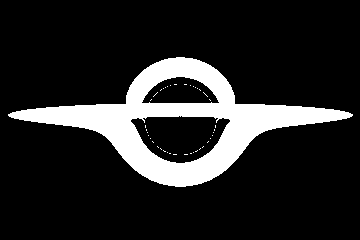

In [27]:
%display plain

display(img1)

%display latex

## Disk thickness
Assume disk optically thin, i.e. light intensity can be additive, but never obstructed by the disk itself. We will assume the intensity is proportional to the pathlength of light through the disk.

This pathlength will depend on the disk profile, and the angle $\theta$ between the disk and the light ray
$$
d = \frac{f(r)}{\sin{\theta}}
$$

To calculate $\theta$, we change frame for a locally flat (orthonormal).

For a point on the accretion disk, we have metric:

In [28]:
r0, phi = var("r_0"), var("phi", latex_name=r"\phi")

p = M((0, r0, pi/2, phi))
g.at(p)[:]

[(2*m - r_0)/r_0         2*m/r_0               0               0]
[        2*m/r_0 (2*m + r_0)/r_0               0               0]
[              0               0           r_0^2               0]
[              0               0               0           r_0^2]

Which is fairly close to being flat. We can tweak a little and check our work using SageManifold's `automorphism_field`, which returns an [automorphism](https://en.wikipedia.org/wiki/Automorphism) of tangent spaces to our manifold M. 

For more info, see [docs](https://doc.sagemath.org/html/en/reference/manifolds/sage/manifolds/differentiable/automorphismfield.html).

In practice this looks like:

In [29]:
fr = C.frame() # get frame from chart

print("Default frame:")
display(fr)

aut = M.automorphism_field() # create am field on 4D Lorentzian M

# try simplest matrix possible
a, b, c = var("a b c")
aut.add_comp()[:] = [
    [a,  0,   0,    0],
    [b,  c,   0,    0], # b is only off-diagonal
    [0,  0,  1/r0,  0],
    [0,  0,   0, 1/r0]
]

print("New frame:")
fr2 = fr.new_frame(aut, "f2")
display(fr2)

Default frame:


Coordinate frame (M, (d/dt,d/dr,d/dtheta,d/dphi))

New frame:


Vector frame (M, (f2_0,f2_1,f2_2,f2_3))

We can see what the metric at $p$ looks like in our new frame:

In [30]:
g2mat = g.at(p)[fr2.at(p), :]
display(g2mat)

[b^2*(2*m + r_0)/r_0 + a^2*(2*m - r_0)/r_0 + 4*a*b*m/r_0                       b*c*(2*m + r_0)/r_0 + 2*a*c*m/r_0                                                       0                                                       0]
[                      b*c*(2*m + r_0)/r_0 + 2*a*c*m/r_0                                     c^2*(2*m + r_0)/r_0                                                       0                                                       0]
[                                                      0                                                       0                                                       1                                                       0]
[                                                      0                                                       0                                                       0                                                       1]

We can now constrain the values of $a$, $b$, and $c$; we do this by setting each corresponding matrix element to the desired $\text{diag}(-1, 1, 1, 1)$, and solving for the respective variable.

In [31]:
c_expr = (g2mat[1][1] == 1)
b_expr = (g2mat[1][0] == 0)
a_expr = (g2mat[0][0] == -1)

solutions = solve([a_expr, b_expr, c_expr], a, b, c)
# pick first, rhs
a, b, c = map(
    lambda i: i.rhs().subs({r0:r}), # substitute r0 for r 
    solutions[0]
)

print("Solutions for a, b, c:")
display([a, b, c])

Solutions for a, b, c:


[sqrt((2*m + r)/r), -2*m*sqrt((2*m + r)/r)/(2*m + r), sqrt(r/(2*m + r))]

Which we can now use for a new frame to check whether we have a flat metric:

In [32]:
aut2 = M.automorphism_field() # new am field
aut2.add_comp()[:] = [
    [a,  0,   0,    0],
    [b,  c,   0,    0], # b is only off-diagonal
    [0,  0,  1/r,  0],
    [0,  0,   0, 1/(r*sin(theta))] # using r, so scaling sin(theta)
]

fr3 = fr.new_frame(aut2, "f3")
g[fr3, :]

[-1  0  0  0]
[ 0  1  0  0]
[ 0  0  1  0]
[ 0  0  0  1]

Which is indeed flat! This frame extends everywhere on M, which is only possible since the frame doesn't correspond to any system of coordinates (else the spacetime itself would be Minkowski).

In this frame, components of 4-velocity will be transformed by:

In [33]:
aut2.inverse()[:]

[      sqrt(r)/sqrt(2*m + r)                           0                           0                           0]
[2*m/(sqrt(2*m + r)*sqrt(r))       sqrt(2*m + r)/sqrt(r)                           0                           0]
[                          0                           0                           r                           0]
[                          0                           0                           0                r*sin(theta)]

The angle $\theta$ is then computed as

$$
\theta = \arctan{\left( \frac{\vec{v}_{\perp}}{\vec{v}_{\parallel}} \right)}.
$$

### Transition maps
Next, we want to find the transition map for the velocity 3-vectors in $\mathbb{E}^3$; that is, a transition spherical coordinates to $x$, $y$, $z$, along with the rotations of $\alpha$ and $\beta$.

*NB:* most variables here use a `t` suffix to denote that they are temporary. This could alternatively be scoped, as to not interfer with globally defined variables.

In [34]:
alpha_t, beta_t = (
    var("alpha", latex_name=r"\alpha"), 
    var("beta", latex_name=r"\beta")
)

spher_t.<r_t, theta_t, phi_t> = E.chart()
xt, yt, zt = to_xyz(r_t, theta_t, phi_t)
xt, yt, zt = rotate_alpha_beta(
    xt, yt, zt,
    alpha_t, beta_t
)

transition_map = spher_t.transition_map(
    E.default_chart(),
    [xt, yt, zt]
)

transition_map.display()

x = r_t*cos(alpha)*cos(phi_t)*sin(theta_t) - (r_t*sin(beta)*sin(phi_t)*sin(theta_t) + r_t*cos(beta)*cos(theta_t))*sin(alpha)
y = r_t*cos(beta)*sin(phi_t)*sin(theta_t) - r_t*cos(theta_t)*sin(beta)
z = r_t*cos(phi_t)*sin(alpha)*sin(theta_t) + (r_t*sin(beta)*sin(phi_t)*sin(theta_t) + r_t*cos(beta)*cos(theta_t))*cos(alpha)

We can now define two Cython functions for coordiate conversions:

In [35]:
%%cython
from libc.math cimport cos, sin, sqrt

cpdef tuple spherical_to_xyz(
    float dr, float dtheta, float dphi, float r,
    float theta, float phi, float alpha, float beta
):    
    cdef float dx, dy, dz
    cdef float ca, cb, ct, cp
    cdef float sa, sb, st, sp
    
    ca = cos(alpha); sa = sin(alpha)
    cb = cos(beta);  sb = sin(beta)
    ct = cos(theta); st = sin(theta)
    cp = cos(phi);   sp = sin(phi)
    
    dx = ((-cb*ct*sa - (sa*sb*sp - ca*cp)*st)*dr + 
          (r*cb*sa*st - (sa*sb*sp - ca*cp)*r*ct)*dtheta +
          (-(cp*sa*sb + ca*sp)*r*st)*dphi)
    
    dy = ((cb*sp*st - sb*ct)*dr +
          (r*ct*cb*sp + r*sb*st)*dtheta +
          (r*cp*cb*st)*dphi)
    
    dz = ((ca*cb*ct + (ca*sb*sp + cp*sa)*st)*dr +
          (-r*ca*cb*st+(ca*sb*sp + cp*sa)*r*ct)*dtheta +
          ((ca*cp*sb - sa*sp)*r*st)*dphi)
    
    return (dx, dy, dz)


cpdef tuple xyz_to_spherical(
    float dx, float dy, float dz, float x, 
    float y, float z
):
    cdef float r, dr, dth, dph
    
    r = sqrt(x**2+y**2+z**2)
    dr = (x*dx+y*dy*z*dz)/r
    dth = ((x*z*dx+y*z*dy)/r**2/sqrt(x**2+y**2)-sqrt(x**2+y**2)*dz)/r**2
    dph = -y/(x**2+y**2)*dx+x/(x**2+y**2)*dy
    
    return (dr, dth, dph)
    

### Disk profile
Now we define a profile for the disk, which can be selected arbitrarily:

In [36]:
%%cython
from libc.math cimport exp, sqrt

cpdef float profile(float x, float r_inner, float r_outer):
    """ normal distribution centered between `r_inner` and `r_outer` """
    cdef float y
    cdef float sigma = 4 # arbitrarily chosen
    cdef float mean = (r_outer - r_inner) / 2 + r_inner
    
    if not (r_inner < x < r_outer):
        return 0
    else:
        y = (1/sigma * sqrt(2 * 3.14)) * exp(-0.5 * ((x - mean) / sigma)**2)
        return max(y, 0)

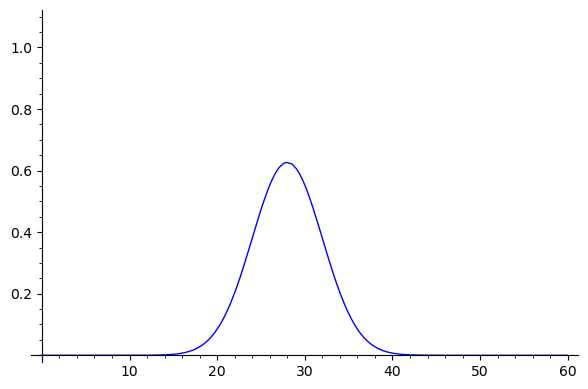

In [37]:
plot(
    lambda x: profile(x, BH_INNER, BH_OUTER), 
    xmin=0, xmax=60, ymin=0, ymax=1.1
)


### Rendering
Next we'll require a new intersection function:

In [49]:
%%cython
from libc.math cimport cos, sin, acos, sqrt, abs, atan2
cimport cython
from __main__ import profile
from __main__ import xyz_to_spherical
from __main__ import spherical_to_xyz
from __main__ import c_to_xyz


@cython.boundscheck(False)
@cython.wraparound(False) # no negative indexes
cpdef inline tuple four_velocity(list curve, int i):
    return (
        curve[i+1][1] - curve[i][1],
        curve[i+1][2] - curve[i][2],
        curve[i+1][3] - curve[i][3],
        curve[i+1][4] - curve[i][4]
    )


cpdef inline tuple xfm_orthonormal(
    float r, float m,
    float dt, float dr, float dtheta, float dphi
):
    return (
        sqrt(r / 2 * m + r) * dt,
        2 * m / (sqrt(r * (2 * m + r))) * dt + sqrt((2 * m + r) / r) * dr,
        dtheta * r,
        dphi * r
    )

@cython.boundscheck(False)
@cython.wraparound(False) # no negative indexes
cpdef intersects_profile(
    list curve, float m, 
    float alpha, float beta, 
    float inner_r, float outer_r
):
    cdef float x, y, z, x2, y2, z2, r, theta, phi
    cdef int n, i
    cdef float t, sinalpha, cosalpha, sinbeta, cosbeta
    
    cdef float thickness=0. # return values
    cdef float dt, dr, dtheta, dphi
    cdef float dx, dy, dz
    cdef float theta_width
    
    # precalculate
    sinalpha = sin(alpha)
    cosalpha = cos(alpha)
    sinbeta = sin(beta)
    cosbeta = cos(beta)
    
    n = len(curve)
    r, theta, phi = curve[0][2:5]
    x, y, z = c_to_xyz(r, theta, phi)
    
    # rotate
    y, z = y * cosbeta - z * sinbeta, z * cosbeta + y * sinbeta
    x, z = x * cosalpha - z * sinalpha, z * cosalpha + x * sinalpha
    
    for i in range(1, n):
        r, theta, phi = curve[i][2:5]
        x2, y2, z2 = c_to_xyz(r, theta, phi)
        
        # rotate
        y2, z2 = y2 * cosbeta - z2 * sinbeta, z2 * cosbeta + y2 * sinbeta
        x2, z2 = x2 * cosalpha - z2 * sinalpha, z2 * cosalpha + x2 * sinalpha
        
        if inner_r < curve[i][2] < outer_r:
            if z != z2:
                t = z / (z - z2)
                if 0 <= t < 1:
                    dt, dr, dtheta, dphi = four_velocity(curve, i)
                    # rotation of 4-vel
                    dx, dy, dz = spherical_to_xyz(
                        dr, dtheta, dphi, 
                        r, theta, phi, 
                        alpha, beta
                    )
                    dr, dtheta, dphi = xyz_to_spherical(
                        dx, dy, dz, 
                        x2, y2, z2
                    )
                    
                    # orthonormal frame
                    dt, dr, dtheta, dphi = xfm_orthonormal(
                        r, m, dt, dr, dtheta, dphi
                    )
                    
                    # angle theta calculation
                    theta_width = atan2(
                        dtheta, sqrt(dr**2 + dphi**2)
                    )
                    
                    # thickness
                    thickness += 40 * profile( # magic number chosen factor
                        r, inner_r, outer_r
                    ) / sin(abs(theta_width))
        x, y, z = x2, y2, z2
        
    # avoid clipping past fully white
    if thickness >= 255:
        thickness = 255
    return (thickness, thickness, thickness)

Next we update our column rendering function to use RGB return values:

In [50]:
def render_column(args):
    g_coords, x = args
    
    global HEIGHT, WIDTH, SCALING_FACTOR
    global alpha_ang, beta_ang, BH_INNER, BH_OUTER
    
    res = np.zeros((HEIGHT, 3))
    
    for y in range(HEIGHT):
        beta = atan2(y - HEIGHT / 2, x) # beta angle
        
        # calc px distance to center
        r = sqrt(x**2 + (y - HEIGHT / 2)**2)
        geodesic_index = int(r / SCALING_FACTOR * NUM_GEOD)
        if geodesic_index < NUM_GEOD:
            res[HEIGHT-1-y, :] = intersects_profile(
                g_coords[geodesic_index],
                BH_INDEX,
                alpha_ang,
                beta + beta_ang,
                BH_INNER,
                BH_OUTER
            )
    return x, res

In [51]:
%display plain

image = np.zeros((HEIGHT, WIDTH, 3), dtype=float)
imageout_thickness = render(geodesics_coords, image)

%display latex

FloatProgress(value=0.0, max=1080.0)

In [52]:
img2 = PILImage.fromarray(np.uint8(imageout_thickness))

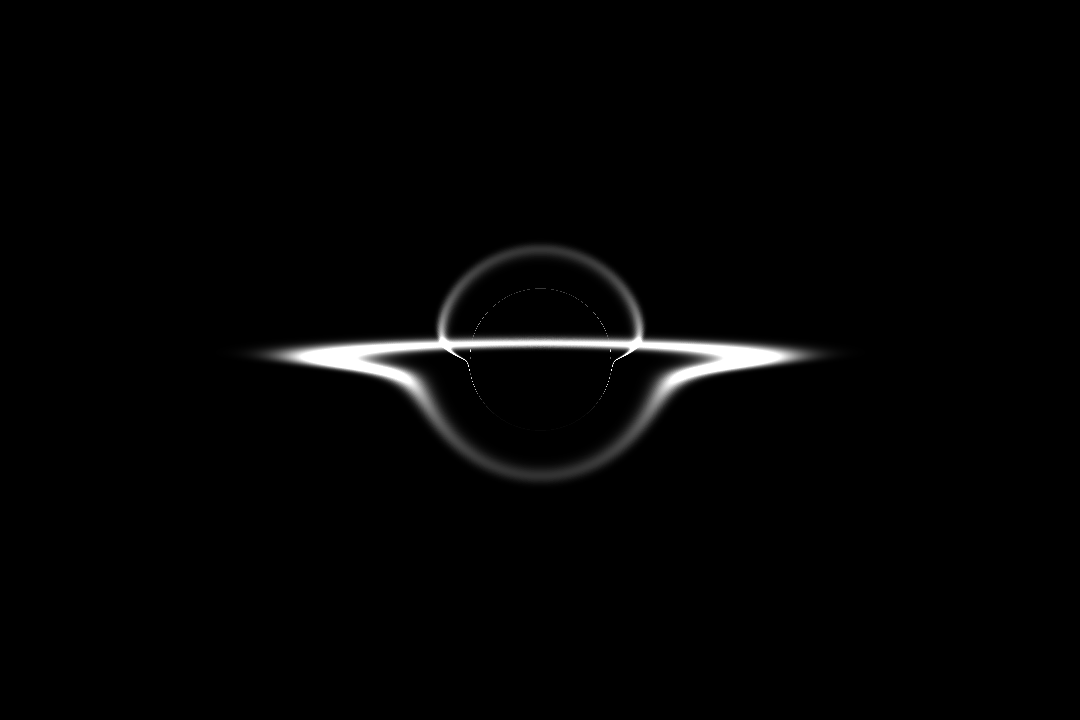

In [53]:
%display plain

display(img2)

%display latex